## Boundaries/Interfaces:

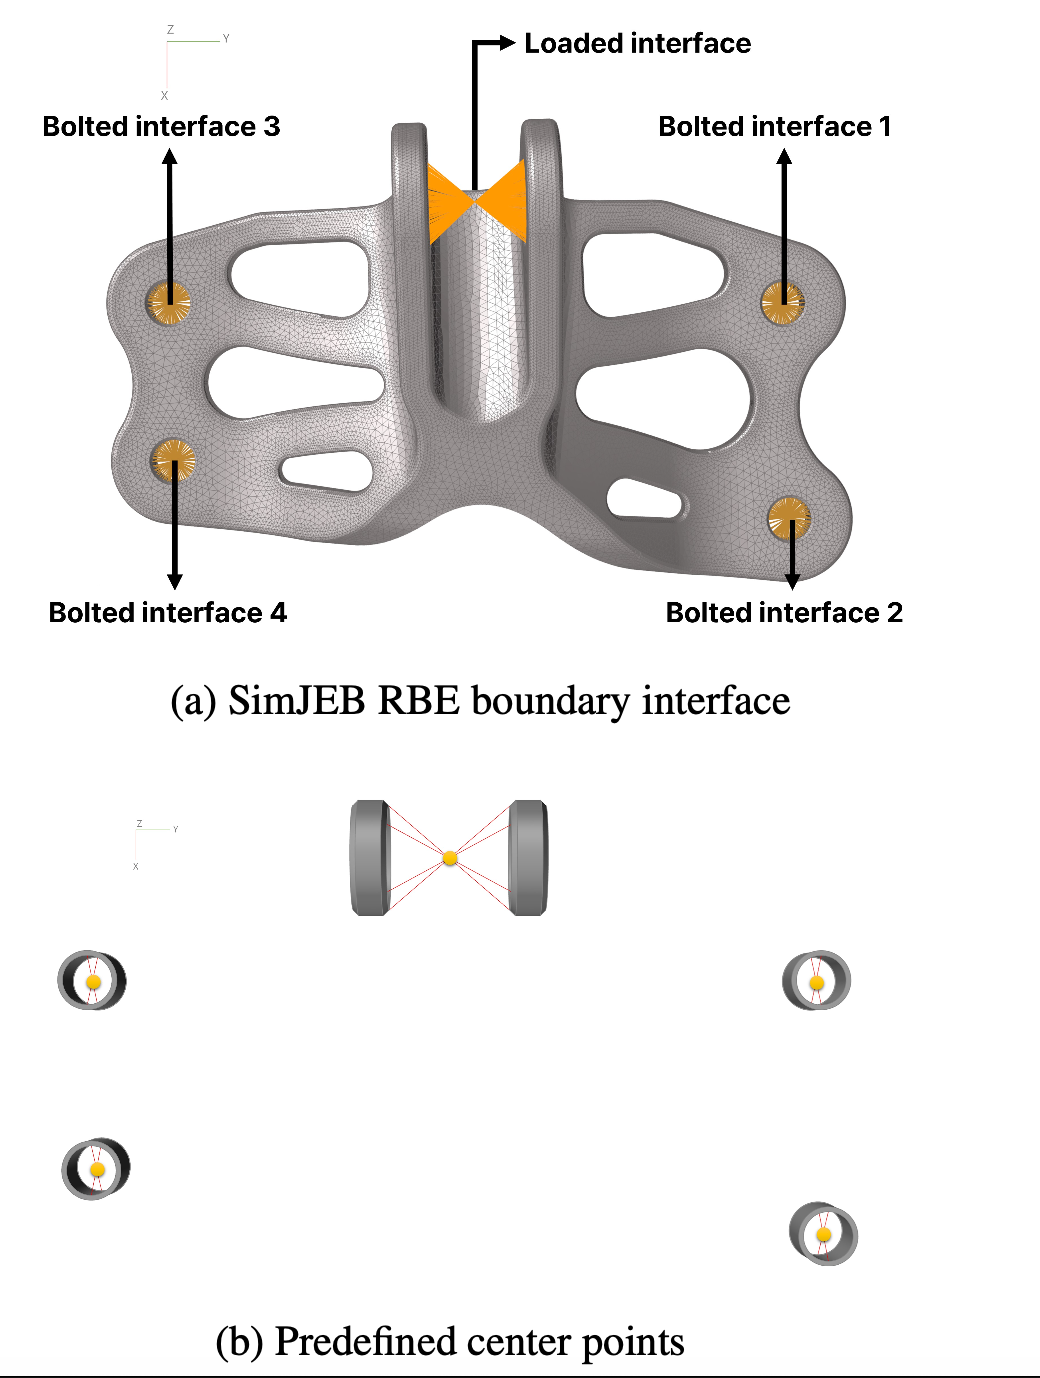 

In [ ]:
import numpy as np
import os
import sys
import trimesh  
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 

# To allow me to import the functiosn from other folders from the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from File_Paths.file_paths import interfaces_path, mesh_path    

print("mesh_path:", mesh_path)
print("interfaces_path:", interfaces_path)

# Import sample part from dataset and interface surfaces 
part_411 = trimesh.load(os.path.join(mesh_path, "411.obj"))
interface_points = trimesh.load(os.path.join(interfaces_path, "interfaces (1).obj"))
pinn1 = trimesh.load(os.path.join(interfaces_path, "pinn_interface_1.obj"))
pinn2 = trimesh.load(os.path.join(interfaces_path, "pinn_interface_2.obj"))
bolt1 = trimesh.load(os.path.join(interfaces_path, "bolt_interface_1.obj"))
bolt2 = trimesh.load(os.path.join(interfaces_path, "bolt_interface_2.obj"))
bolt3 = trimesh.load(os.path.join(interfaces_path, "bolt_interface_3.obj"))
bolt4 = trimesh.load(os.path.join(interfaces_path, "bolt_interface_4.obj"))

# Calculate the centroids of the interfaces
pinn1_centroid = pinn1.bounding_box.centroid
pinn2_centroid = pinn2.bounding_box.centroid
bolt1_centroid = bolt1.bounding_box.centroid
bolt2_centroid = bolt2.bounding_box.centroid
bolt3_centroid = bolt3.bounding_box.centroid
bolt4_centroid = bolt4.bounding_box.centroid
centroids = np.array([pinn1_centroid, pinn2_centroid, bolt1_centroid, bolt2_centroid, bolt3_centroid, bolt4_centroid])


In [ ]:

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=1
    ),
    name='Centroids'
))

# Add mesh plot of part_411
verts1 = part_411.vertices
faces1 = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts1[:, 0], y=verts1[:, 1], z=verts1[:, 2],
    i=faces1[:, 0], j=faces1[:, 1], k=faces1[:, 2],
    color='lightgray',
    opacity=0.4,
    flatshading=True,
    name='Part 411'
))

# Add mesh plot of interface_points 
verts2 = interface_points.vertices
faces2 = interface_points.faces
fig.add_trace(go.Mesh3d(
    x=verts2[:, 0], y=verts2[:, 1], z=verts2[:, 2],
    i=faces2[:, 0], j=faces2[:, 1], k=faces2[:, 2],
    color='blue',
    opacity=1,
    flatshading=True,
    name='Interface Points'
))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=30),
    title="Jet Engine Bracket: Combined Plots"
)

fig.show()

**Define the regions of the design space that is not allowed to be occupied by material --> To avoid blocking of the mounting interfaces**

In [ ]:
from Test_Cases.Jet_Engine_Bracket.boundary_surfaces import Bolt_interface_cylindrical_boundary
from Test_Cases.Jet_Engine_Bracket.boundary_surfaces import Pinn_interface_cylindrical_boundary

bounds = part_411.bounding_box.bounds

# Convert into an array --> [x_min, x_max, y_min, y_max, z_min, z_max]
domain = np.array([bounds[0][0], bounds[1][0], bounds[0][1], bounds[1][1], bounds[0][2], bounds[1][2]])

# Define prohibited regions without radius input 
pinn1_prohibited_region = Pinn_interface_cylindrical_boundary(pinn1_centroid, pinn2_centroid , domain)
bolt1_prohibited_region = Bolt_interface_cylindrical_boundary(bolt1_centroid, domain)
bolt2_prohibited_region = Bolt_interface_cylindrical_boundary(bolt2_centroid, domain)
bolt3_prohibited_region = Bolt_interface_cylindrical_boundary(bolt3_centroid, domain)
bolt4_prohibited_region = Bolt_interface_cylindrical_boundary(bolt4_centroid, domain)



In [ ]:
print("domain: ", domain)

**Test the functions that we will use to determine if points are inside or outside the prohibited region:**


In [ ]:
# Create a uniform point grid within the domain
x = np.linspace(domain[0], domain[1], 100)
y = np.linspace(domain[2], domain[3], 100)
z = np.linspace(domain[4], domain[5], 100)
X, Y, Z = np.meshgrid(x, y, z)
points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T 

In [ ]:

# Check if points are inside the prohibited regions
inside_points_bolt1, inside_bolt1_idx = bolt1_prohibited_region.extract_inside_interface_points(points)
inside_points_bolt2, inside_bolt2_idx = bolt2_prohibited_region.extract_inside_interface_points(points)
inside_points_bolt3, inside_bolt3_idx = bolt3_prohibited_region.extract_inside_interface_points(points)
inside_points_bolt4, inside_bolt4_idx = bolt4_prohibited_region.extract_inside_interface_points(points)
inside_points_pinn1, inside_pinn1_idx = pinn1_prohibited_region.extract_inside_interface_points(points)
inside_points = np.vstack([inside_points_bolt1, inside_points_bolt2, inside_points_bolt3, inside_points_bolt4, inside_points_pinn1])
inside_idx = np.hstack([inside_bolt1_idx, inside_bolt2_idx, inside_bolt3_idx, inside_bolt4_idx, inside_pinn1_idx])

# Check if points are on the surface of the prohibited regions
surface_points_bolt1, surface_bolt1_idx = bolt1_prohibited_region.extract_interface_surface_points(points)
surface_points_bolt2, surface_bolt2_idx = bolt2_prohibited_region.extract_interface_surface_points(points)
surface_points_bolt3, surface_bolt3_idx = bolt3_prohibited_region.extract_interface_surface_points(points)
surface_points_bolt4, surface_bolt4_idx = bolt4_prohibited_region.extract_interface_surface_points(points)
surface_points_pinn1, surface_pinn1_idx = pinn1_prohibited_region.extract_interface_surface_points(points)
surface_points = np.vstack([surface_points_bolt1, surface_points_bolt2, surface_points_bolt3, surface_points_bolt4, surface_points_pinn1])
surface_idx = np.hstack([surface_bolt1_idx, surface_bolt2_idx, surface_bolt3_idx, surface_bolt4_idx, surface_pinn1_idx]) 


**Plot the regions of the design space where material is prohibited**

In [ ]:
# Plot the points on the surface and inside the prohibited regions
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=inside_points[:, 0],
    y=inside_points[:, 1],
    z=inside_points[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=1
    ),
    name='Inside Points'
))

   
# Add mesh plot of part_411
verts1 = part_411.vertices
faces1 = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts1[:, 0], y=verts1[:, 1], z=verts1[:, 2],
    i=faces1[:, 0], j=faces1[:, 1], k=faces1[:, 2],
    color='blue',
    opacity=0.1,
    flatshading=True,
    name='Part 411'
))

fig.show()

## Defining Geometrical Features: 

- We can use our surface definitions to enforce a minimum thickness around the bolted interfaces or the pinn holes! 
- We can enforce certain geometrical features, such as mounting geometry for the bolts 

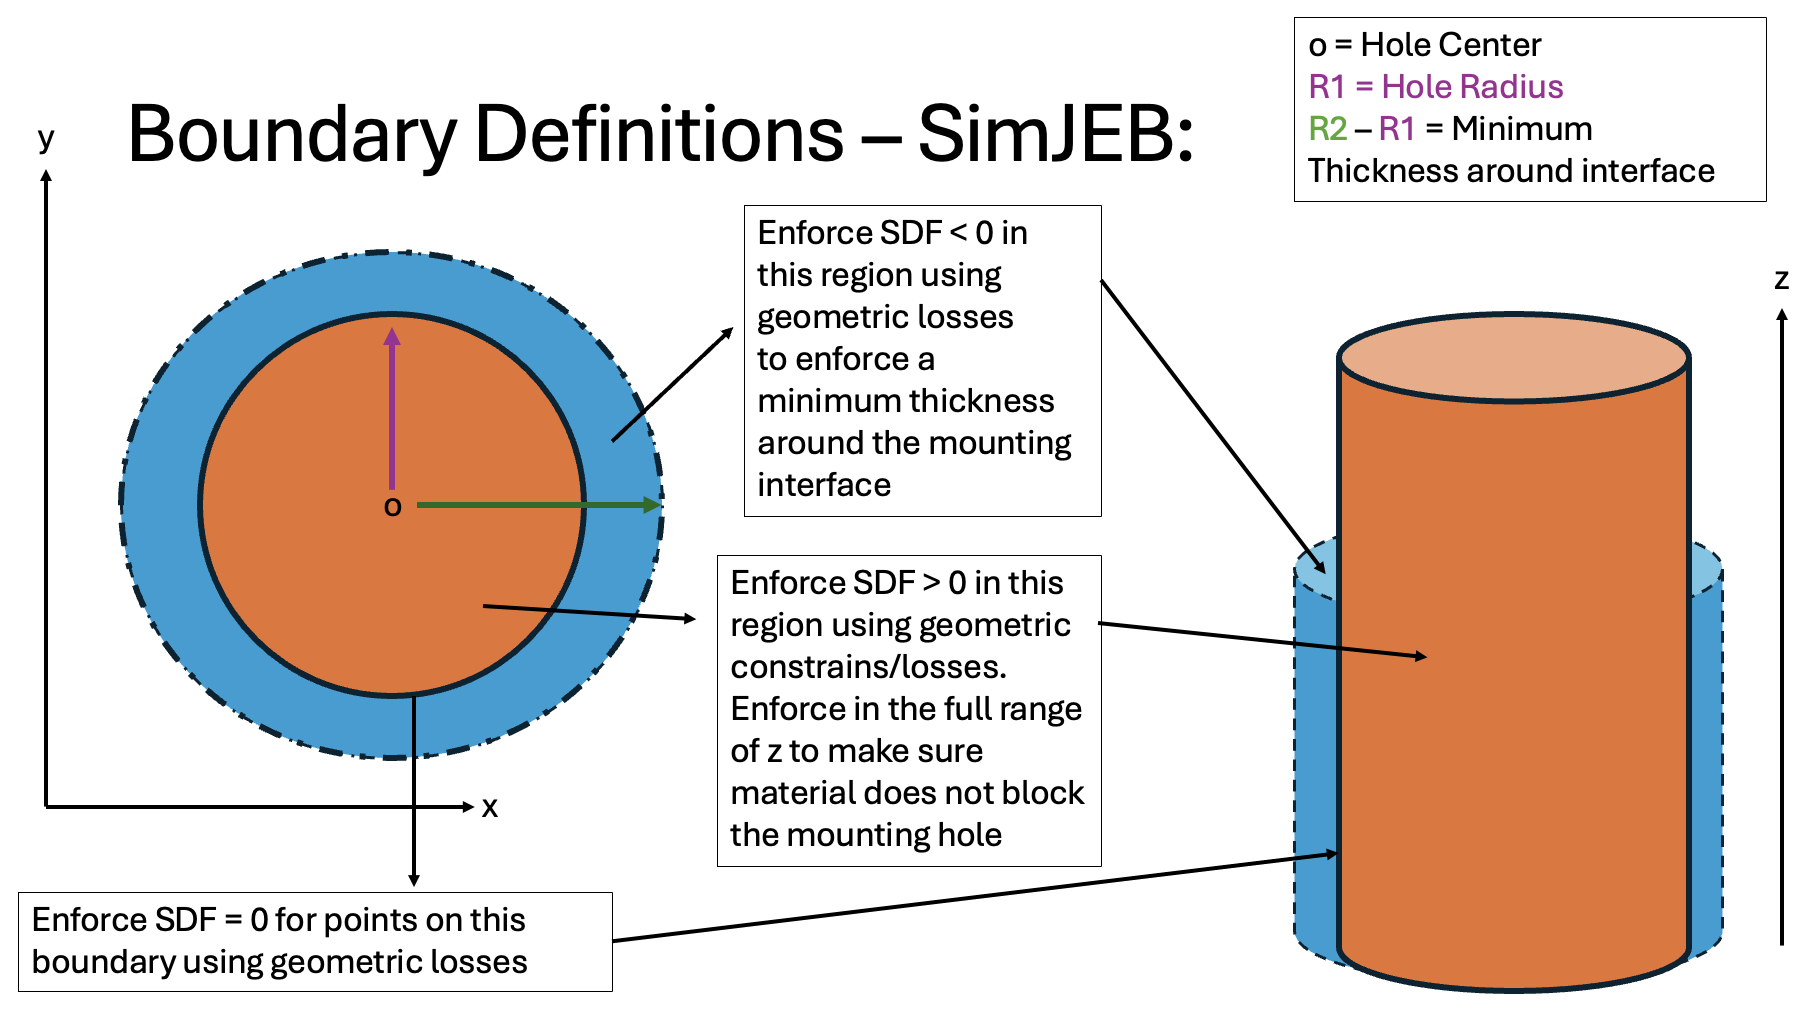
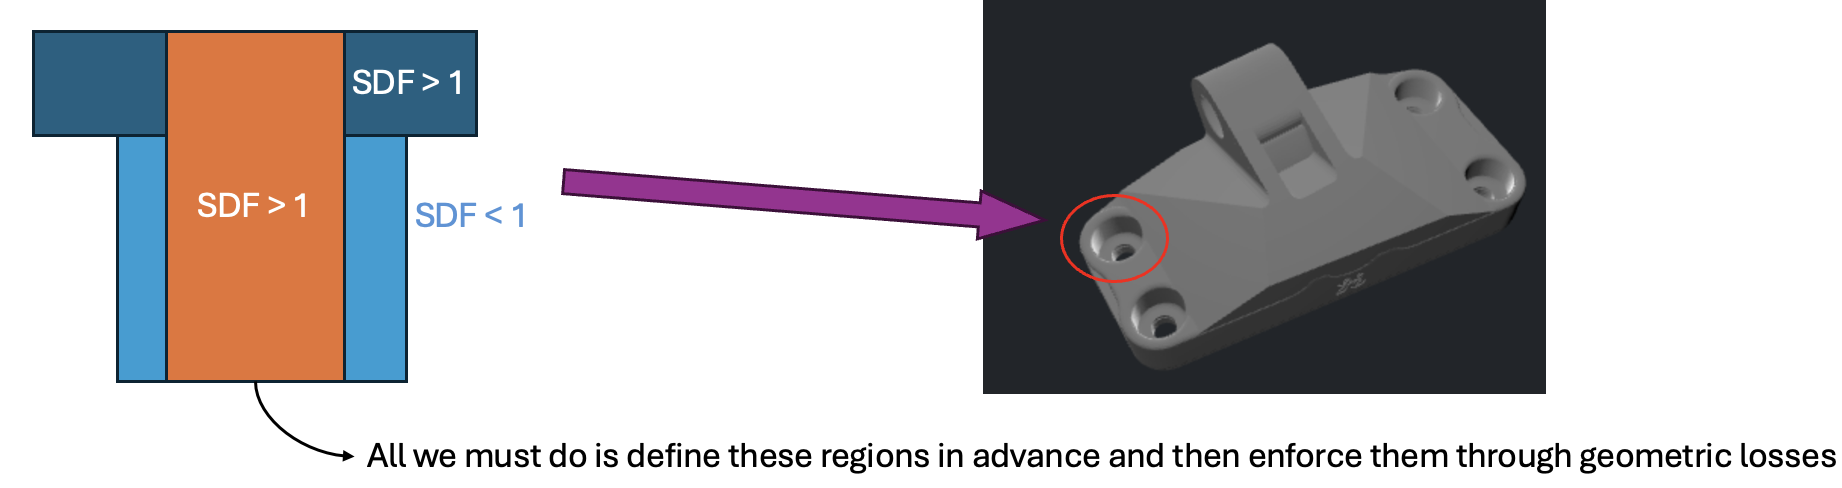

**Generate cylindrical interface region with optional features**

In [ ]:
# Random Values to test the functionality
prescribed_bolt_interface_dept = 10
prescribed_bolt_thickness = 6.9431 
counterbore_interface_thickness = 5
counterbore_dept = 15

# Create a prohibited region for the bolt interface - with counterbore feature
bolt1_prohibited_with_counterbore = Bolt_interface_cylindrical_boundary(bolt1_centroid,
                                                                        domain,
                                                                        prescribed_interface_thickness = True,
                                                                        prescribed_interface_thickness_value = prescribed_bolt_thickness,
                                                                        prescribed_interface_depth = prescribed_bolt_interface_dept,
                                                                        counterbore = True,
                                                                        counterbore_interface_thickness = counterbore_interface_thickness,
                                                                        counterbore_depth = counterbore_dept)

bolt2_prohibited_with_counterbore = Bolt_interface_cylindrical_boundary(bolt2_centroid,
                                                                        domain,
                                                                        prescribed_interface_thickness = True,
                                                                        prescribed_interface_thickness_value = prescribed_bolt_thickness,
                                                                        prescribed_interface_depth = prescribed_bolt_interface_dept,
                                                                        counterbore = True,
                                                                        counterbore_interface_thickness = counterbore_interface_thickness,
                                                                        counterbore_depth = counterbore_dept)

bolt3_prohibited_with_counterbore = Bolt_interface_cylindrical_boundary(bolt3_centroid,
                                                                        domain,
                                                                        prescribed_interface_thickness = True,
                                                                        prescribed_interface_thickness_value = prescribed_bolt_thickness,
                                                                        prescribed_interface_depth = prescribed_bolt_interface_dept,
                                                                        counterbore = True,
                                                                        counterbore_interface_thickness = counterbore_interface_thickness,
                                                                        counterbore_depth = counterbore_dept)

bolt4_prohibited_with_counterbore = Bolt_interface_cylindrical_boundary(bolt4_centroid,
                                                                        domain,
                                                                        prescribed_interface_thickness = True,
                                                                        prescribed_interface_thickness_value = prescribed_bolt_thickness,
                                                                        prescribed_interface_depth = prescribed_bolt_interface_dept,
                                                                        counterbore = True,
                                                                        counterbore_interface_thickness = counterbore_interface_thickness,
                                                                        counterbore_depth = counterbore_dept)

pinn1_prohibited_with_prescribed_thickness = Pinn_interface_cylindrical_boundary(pinn1_centroid,
                                                                                 pinn2_centroid , 
                                                                                 domain,
                                                                                # prescribed_radial_thickness=True,
                                                                                 prescribed_radial_thickness_value=5,
                                                                                # prescribed_minimum_width=True,
                                                                                 prescribed_minimum_width_value=10,
                                                                                 prescribed_sharp_edges=True)



**Test the functions to extract the points inside the prohibited regions of the design space and the thicknes regions around the interfaces. These wll be used to calculate losses**

In [ ]:
# Extract the inside and surface points
inside_points_bolt1, inside_bolt1_idx = bolt1_prohibited_with_counterbore.extract_inside_interface_points(points)
surface_points_bolt1, surface_bolt1_idx = bolt1_prohibited_with_counterbore.extract_interface_surface_points(points)

inside_points_bolt2, inside_bolt2_idx = bolt2_prohibited_with_counterbore.extract_inside_interface_points(points)
surface_points_bolt2, surface_bolt2_idx = bolt2_prohibited_with_counterbore.extract_interface_surface_points(points)

inside_points_bolt3, inside_bolt3_idx = bolt3_prohibited_with_counterbore.extract_inside_interface_points(points)
surface_points_bolt3, surface_bolt3_idx = bolt3_prohibited_with_counterbore.extract_interface_surface_points(points)

inside_points_bolt4, inside_bolt4_idx = bolt4_prohibited_with_counterbore.extract_inside_interface_points(points)
surface_points_bolt4, surface_bolt4_idx = bolt4_prohibited_with_counterbore.extract_interface_surface_points(points)

inside_points_pinn1, inside_pinn1_idx = pinn1_prohibited_with_prescribed_thickness.extract_inside_interface_points(points)

inside_points = np.vstack([inside_points_bolt1, inside_points_bolt2, inside_points_bolt3, inside_points_bolt4, inside_points_pinn1])
surface_points = np.vstack([surface_points_bolt1, surface_points_bolt2, surface_points_bolt3, surface_points_bolt4, surface_points_pinn1])



# Extract the points inside the thickness of the bolt interface
bolt1_thoickness_points = bolt1_prohibited_with_counterbore.extract_inside_interface_thickness_points(points)[0]
bolt2_thoickness_points = bolt2_prohibited_with_counterbore.extract_inside_interface_thickness_points(points)[0]
bolt3_thoickness_points = bolt3_prohibited_with_counterbore.extract_inside_interface_thickness_points(points)[0]
bolt4_thoickness_points = bolt4_prohibited_with_counterbore.extract_inside_interface_thickness_points(points)[0]

pinn1_thickness_points = pinn1_prohibited_with_prescribed_thickness.extract_inside_interface_thickness_points(points)[0]

bolt_thickness_points = np.vstack([bolt1_thoickness_points, bolt2_thoickness_points, bolt3_thoickness_points, bolt4_thoickness_points])

# Extract points inside the counterbore thickness
bolt1_counterbore_thickness_points = bolt1_prohibited_with_counterbore.extract_counterbore_interface_thickness_points(points)[0]
bolt2_counterbore_thickness_points = bolt2_prohibited_with_counterbore.extract_counterbore_interface_thickness_points(points)[0]
bolt3_counterbore_thickness_points = bolt3_prohibited_with_counterbore.extract_counterbore_interface_thickness_points(points)[0]
bolt4_counterbore_thickness_points = bolt4_prohibited_with_counterbore.extract_counterbore_interface_thickness_points(points)[0]



counterbore_thickness_points = np.vstack([bolt1_counterbore_thickness_points, bolt2_counterbore_thickness_points, bolt3_counterbore_thickness_points, bolt4_counterbore_thickness_points])


**Plot the thickness and prohibited regions to validate the surface definitions**

In [ ]:
inside_pts         = inside_points
surface_pts        = surface_points
thickness_pts      = bolt_thickness_points
counterbore_pts    = counterbore_thickness_points

fig = go.Figure()

# 1) Solid prohibited volume 
fig.add_trace(go.Scatter3d(
    x=inside_pts[:,0], y=inside_pts[:,1], z=inside_pts[:,2],
    mode='markers',
    marker=dict(size=2, color='red', opacity=1),
    name='Prohibited core'
))

# 2) interface thickness
fig.add_trace(go.Scatter3d(
    x=thickness_pts[:,0], y=thickness_pts[:,1], z=thickness_pts[:,2],
    mode='markers',
    marker=dict(size=2, color='orange', opacity=0),
    name='Bolt-thickness shell'
))

# 3) counterbore thickness
fig.add_trace(go.Scatter3d(
    x=counterbore_pts[:,0], y=counterbore_pts[:,1], z=counterbore_pts[:,2],
    mode='markers',
    marker=dict(size=2, color='green', opacity=0),
    name='Counterbore-thickness shell'
))

# 4) Points inside the pinn interface thickness region 
fig.add_trace(go.Scatter3d(
    x=pinn1_thickness_points[:,0], y=pinn1_thickness_points[:,1], z=pinn1_thickness_points[:,2],
    mode='markers',
    marker=dict(size=2, color='purple', opacity=0),
    name='Pinn-thickness shell'
))



verts = part_411.vertices; faces = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts[:,0], y=verts[:,1], z=verts[:,2],
    i=faces[:,0], j=faces[:,1], k=faces[:,2],
    color='blue', opacity=0, name='Part 411'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    title="Bolt & Counterbore Prohibited Regions"
)
fig.show()

**Test the functions to sample points on the surface of the interfaces:**

In [ ]:
num_points = 1000

# Sample points from the bolt interface
bolt_interface_test1 = bolt1_prohibited_with_counterbore.sample_points_from_bolt_interface(num_points)
bolt_interface_test2 = bolt2_prohibited_with_counterbore.sample_points_from_bolt_interface(num_points)
bolt_interface_test3 = bolt3_prohibited_with_counterbore.sample_points_from_bolt_interface(num_points)
bolt_interface_test4 = bolt4_prohibited_with_counterbore.sample_points_from_bolt_interface(num_points)
sampled_points_bolt = np.vstack([bolt_interface_test1, bolt_interface_test2, bolt_interface_test3, bolt_interface_test4])

# Sample points from the PINN interface
pinn_interface_test = pinn1_prohibited_with_prescribed_thickness.sample_points_from_pinn_interface(num_points)

In [ ]:
fig = go.Figure()
pts = sampled_points_bolt
pts_pinn = pinn_interface_test

fig.add_trace(go.Scatter3d(
    x=pts[:,0], y=pts[:,1], z=pts[:,2],
    mode='markers',
    marker=dict(size=2, color='red', opacity=1),
    name='Bolt Surface Points'
))

fig.add_trace(go.Scatter3d(
    x=pts_pinn[:,0], y=pts_pinn[:,1], z=pts_pinn[:,2],
    mode='markers',
    marker=dict(size=2, color='red', opacity=1),
    name='Pinn Surface Points'
))


verts = part_411.vertices; faces = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts[:,0], y=verts[:,1], z=verts[:,2],
    i=faces[:,0], j=faces[:,1], k=faces[:,2],
    color='blue', opacity=0.3, name='Part 411'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    title="" \
    "Sampled Points from Bolt Interface"
)
fig.show()

In [ ]:
from Test_Cases.Jet_Engine_Bracket.JEB_Master_object import JEB_Master_object
JEB_123 = JEB_Master_object(Normalize=False)
JEB_123.create_interfaces() 

# Sample points from the surface of the counterbore interface
counterbore_pts = JEB_123.interfaces.sample_points_from_counterbore_interface(num_points = 5000) 
disc_points = JEB_123.interfaces.is_on_counterbore_hollow_disc_interface(points=counterbore_pts) 
cylinder_points = JEB_123.interfaces.is_on_counterbore_cylindrical_interface(points=counterbore_pts)

fig = go.Figure()
pts = counterbore_pts

fig.add_trace(go.Scatter3d(
    x=cylinder_points[0][:, 0], y=cylinder_points[0][:, 1], z=cylinder_points[0][:, 2],
    mode='markers',
    marker=dict(size=1, color='red', opacity=0.5),
    name='Counterbore Surface Points'
))
# Add points on the disc interface 
if disc_points[0].size > 0:  
    fig.add_trace(go.Scatter3d(
        x=disc_points[0][:, 0], y=disc_points[0][:, 1], z=disc_points[0][:, 2],
        mode='markers',
        marker=dict(size=2, color='green', opacity=1),
        name='Counterbore Disc Points'
    ))


verts = part_411.vertices; faces = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts[:,0], y=verts[:,1], z=verts[:,2],
    i=faces[:,0], j=faces[:,1], k=faces[:,2],
    color='blue', opacity=0.1, name='Part 411'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    title="" \
    "Sampled Points from Bolt Interface"
)
fig.show()


In [ ]:
fig = go.Figure()
pts = counterbore_pts


fig.add_trace(go.Scatter3d(
    x=cylinder_points[0][:, 0], y=cylinder_points[0][:, 1], z=cylinder_points[0][:, 2],
    mode='markers',
    marker=dict(size=1, color='red', opacity=0.5),
    name='Counterbore Surface Points'
))


if disc_points[0].size > 0:
    fig.add_trace(go.Scatter3d(
        x=disc_points[0][:, 0], y=disc_points[0][:, 1], z=disc_points[0][:, 2],
        mode='markers',
        marker=dict(size=2, color='green', opacity=1),
        name='Counterbore Disc Points'
    ))

verts = part_411.vertices; faces = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts[:,0], y=verts[:,1], z=verts[:,2],
    i=faces[:,0], j=faces[:,1], k=faces[:,2],
    color='blue', opacity=0.1, name='Part 411'
))

# White background, no axes/grid/box
fig.update_layout(
    title="Sampled Points from Bolt Interface",
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=30, b=0),
    template="none"
)
fig.update_scenes(
    bgcolor="white",
    aspectmode="data",
    xaxis_visible=False, yaxis_visible=False, zaxis_visible=False,
    xaxis_showgrid=False, yaxis_showgrid=False, zaxis_showgrid=False,
    xaxis_showbackground=False, yaxis_showbackground=False, zaxis_showbackground=False,
    xaxis_title_text="", yaxis_title_text="", zaxis_title_text=""
)

fig.show()

## Defining Load Surfaces:



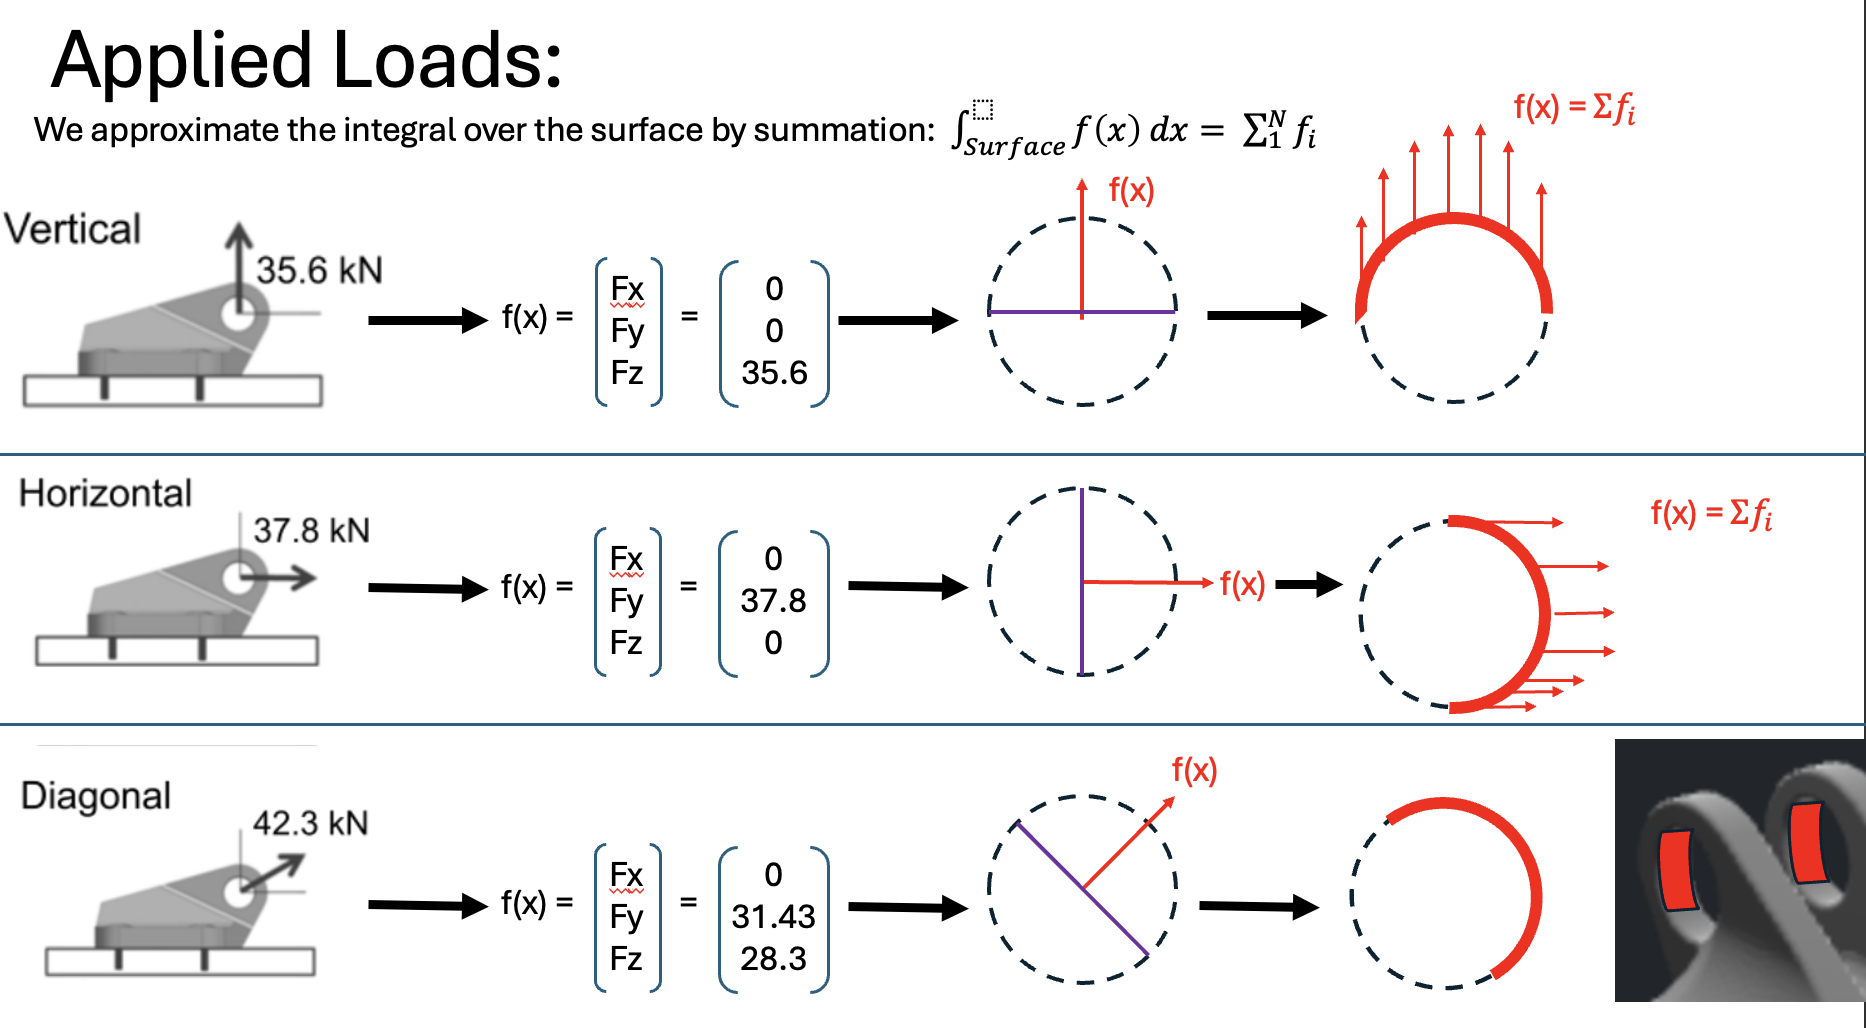 

In [ ]:
num_points = 3000
vertical_load_case_points = pinn1_prohibited_with_prescribed_thickness.sample_points_on_load_surface(num_points, load_type="vertical")
horizontal_load_case_points = pinn1_prohibited_with_prescribed_thickness.sample_points_on_load_surface(num_points, load_type="horizontal")
diagonal_load_case_points = pinn1_prohibited_with_prescribed_thickness.sample_points_on_load_surface(num_points, load_type="diagonal")

In [ ]:
fig = go.Figure()
pts = vertical_load_case_points
pts_bolt = sampled_points_bolt

# 1) Points
fig.add_trace(go.Scatter3d(
    x=pts[:,0], y=pts[:,1], z=pts[:,2],
    mode='markers',
    marker=dict(size=2, color='green', opacity=1),
    name='Bolt Surface Points'
))

fig.add_trace(go.Scatter3d(
    x=pts_bolt[:,0], y=pts_bolt[:,1], z=pts_bolt[:,2],
    mode='markers',
    marker=dict(size=2, color='red', opacity=1),
    name='Bolt Surface Points'
))

# Mesh
verts = part_411.vertices; faces = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts[:,0], y=verts[:,1], z=verts[:,2],
    i=faces[:,0], j=faces[:,1], k=faces[:,2],
    color='blue', opacity=0.2, name='Part 411'
))

# White background, no axes/grid/box
fig.update_layout(
    title="Points on Load Surface",
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=30, b=0),
    template="none"
)
fig.update_scenes(
    bgcolor="white",
    aspectmode="data",
    xaxis_visible=False, yaxis_visible=False, zaxis_visible=False,
    xaxis_showgrid=False, yaxis_showgrid=False, zaxis_showgrid=False,
    xaxis_showbackground=False, yaxis_showbackground=False, zaxis_showbackground=False,
    xaxis_title_text="", yaxis_title_text="", zaxis_title_text=""
)

fig.show()

## Combining all into one class object!
- New function to obtain all information about the interfaces and prohibited regions from one object instead of 5 different ones

In [ ]:
from Test_Cases.Jet_Engine_Bracket.boundary_surfaces import Jet_engine_bracket_interfaces 

JEB_interfaces = Jet_engine_bracket_interfaces(
                                            domain = domain,

                                            # Location of the bolt interfaces
                                            centroid_bolt_interface_1 = bolt1_centroid,
                                            centroid_bolt_interface_2 = bolt2_centroid,
                                            centroid_bolt_interface_3 = bolt3_centroid,
                                            centroid_bolt_interface_4 = bolt4_centroid,
                                            # Location of the PINN interfaces
                                            centroid_pinn_interface_1 = pinn1_centroid,
                                            centroid_pinn_interface_2 = pinn2_centroid, 

                                            # Parameters for the bolt interface
                                            prescribed_bolt_interface_thickness = True, 
                                            prescribed_bolt_interface_thickness_value = 6.9431, 
                                            prescribed_bolt_interface_depth = 10, # mm 
                                            counterbore = True,
                                            counterbore_radius = 20,
                                            counterbore_interface_thickness = 5,
                                            counterbore_depth = 15,

                                            # Parameters for the PINN interface
                                            prescribed_radial_thickness_value = 5,
                                            prescribed_minimum_width_value = 5,
                                            prescribed_sharp_edges = True)
                                               

In [ ]:
# Use the sampling function we will be using in the future to test the functionality
from Functions.Point_Sampling.point_sampler import Point_Sampler 

num_points_domain = 100000
num_points_interface = 10000


point_sampler = Point_Sampler(domain, JEB_interfaces ,num_points_domain, num_points_interface)
points = next(point_sampler) # Get the points from the point sampler



In [ ]:
# Functions to use for GINN losses
points_inside_prohibited_region,    point_indices_1   =  JEB_interfaces.is_inside_prohibited_region(points)
points_inside_prescribed_thickness, point_indices_1   =  JEB_interfaces.is_inside_interface_thickness(points)
points_on_bolt_interface_surface,   point_indices_2   =  JEB_interfaces.is_on_bolt_interface(points) 
points_on_pinn_interface_surface,   point_indices_3   =  JEB_interfaces.is_on_pinn_interface(points)

# Functions to use for PINN losses

#1. Find the points from a point cloud or point grid that are on the Dirichlet or Neumann boundary
points_on_dirichlet_surface, point_indices_4   =    JEB_interfaces.is_on_dirichlet_boundary(points)
points_on_neumann_surface,   point_indices_5   =    JEB_interfaces.is_on_neumann_boundary(points,load_type= "diagonal")

#2. Sample points on the Dirichlet or Neumann boundary
sampled_points_dirichlet_boundary   =   JEB_interfaces.sample_points_on_dirichlet_boundary(num_points = 1000) 
sampled_points_neumann_boundary     =   JEB_interfaces.sample_points_on_neumann_boundary(num_points = 1000, load_type = "diagonal")

# Functions to be used for point sampling  
points_all_interfaces = JEB_interfaces.sample_points_from_all_interfaces(num_points = 1000)


In [ ]:

fig = go.Figure()
pts = points_inside_prohibited_region


fig.add_trace(go.Scatter3d(
    x=pts[:,0], y=pts[:,1], z=pts[:,2],
    mode='markers',
    marker=dict(size=2, color='red', opacity=1),
    name='Bolt Surface Points'
))

verts = part_411.vertices; faces = part_411.faces
fig.add_trace(go.Mesh3d(
    x=verts[:,0], y=verts[:,1], z=verts[:,2],
    i=faces[:,0], j=faces[:,1], k=faces[:,2],
    color='blue', opacity=0, name='Part 411'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    title="" \
    "Points on Load Surface" 
)
fig.show()